In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Add, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import cv2

# Define paths (adjust if needed)
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Classes
classes = ['angry', 'happy', 'neutral']
num_classes = len(classes)

# Image size
img_size = (48, 48)

In [15]:
# Data augmentation for train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split 20% of train for validation
)

# Validation and test: only rescale
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=64,  # Balanced for M3
    color_mode='grayscale',
    classes=classes,
    class_mode='categorical',
    subset='training'
)

# Validation generator (from train split)
val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=64,
    color_mode='grayscale',
    classes=classes,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=64,
    color_mode='grayscale',
    classes=classes,
    class_mode='categorical',
    shuffle=False  # For evaluation
)

# Compute class weights for imbalance
class_indices = train_generator.class_indices  # {'angry':0, 'happy':1, 'neutral':2}
num_classes = len(classes)
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

Found 12940 images belonging to 3 classes.
Found 3235 images belonging to 3 classes.
Found 3965 images belonging to 3 classes.
Class weights: {0: np.float64(1.3496036712557364), 1: np.float64(0.7472857472857473), 2: np.float64(1.085934877475663)}


In [16]:
# Build custom CNN
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('model1_best.h5', monitor='val_accuracy', save_best_only=True)

# Train
history1 = model1.fit(
    train_generator,
    epochs=50,  # Adjust based on time; early stop will halt
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint]
)

# Plot training
plt.plot(history1.history['accuracy'], label='train_acc')
plt.plot(history1.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

/Users/bhanukapannipitiya/Desktop/Campus/ComputerVision/emotion-recognition-project/env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/bhanukapannipitiya/Desktop/Campus/ComputerVision/emotion-recognition-project/env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 20/203 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.3180 - loss: 2.0210

KeyboardInterrupt: 

In [ ]:
# For transfer, convert grayscale to RGB by repeating channels
def grayscale_to_rgb(x):
    return np.repeat(x, 3, axis=-1)  # Apply in generator if needed, but Keras can handle with input_shape

# Build transfer model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48,48,3))
base_model.trainable = False  # Freeze base

inputs = Input(shape=(48,48,1))
x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])  # Grayscale to RGB
x = base_model(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs, outputs)
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Unfreeze some layers for fine-tuning (after initial training if needed)
# For now, train top layers

# Train
history2 = model2.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, ModelCheckpoint('model2_best.h5', monitor='val_accuracy', save_best_only=True)]
)

# Plot
plt.plot(history2.history['accuracy'], label='train_acc')
plt.plot(history2.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# Fine-tune: Unfreeze top layers
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Fine-tune last 20
    layer.trainable = False

model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Lower LR
history2_fine = model2.fit(
    train_generator,
    epochs=20,  # Shorter for fine-tune
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, ModelCheckpoint('model2_fine_best.h5', monitor='val_accuracy', save_best_only=True)]
)

In [17]:
# Load best models
from tensorflow.keras.models import load_model
best_model1 = load_model('model1_best.h5')
best_model2 = load_model('model2_fine_best.h5')  # Or model2_best.h5 if fine-tune not better

# Evaluate on test set
def evaluate_model(model, generator):
    loss, acc = model.evaluate(generator)
    print(f"Test Accuracy: {acc}")
    y_pred = np.argmax(model.predict(generator), axis=1)
    y_true = generator.classes
    print(classification_report(y_true, y_pred, target_names=classes))
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.xticks(range(num_classes), classes)
    plt.yticks(range(num_classes), classes)
    plt.show()

print("Model 1 Evaluation:")
evaluate_model(best_model1, test_generator)

print("Model 2 Evaluation:")
evaluate_model(best_model2, test_generator)

# Choose best: Compare F1-scores (macro avg for balance). Model 2 likely better due to pre-trained features.
# Justify: Custom CNN is simple/from-scratch (good for understanding), Transfer is efficient/advanced (higher scores, real-world deployable on mobile).

TypeError: Could not locate function 'grayscale_to_rgb'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'grayscale_to_rgb', 'registered_name': 'function'}

In [18]:
# Face alignment and noise reduction function (Fixed to return (48, 48, 1) shape)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def align_and_denoise(image):
    if len(image.shape) == 3 and image.shape[2] == 1:
        image = image.squeeze()  # Remove channel if single-channel
    gray = image.astype(np.uint8)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face = gray[y:y+h, x:x+w]
        face = cv2.GaussianBlur(face, (3, 3), 0)  # Light denoising
        face = cv2.resize(face, img_size).astype(np.float32) / 255.0  # Normalize to [0, 1]
        return np.expand_dims(face, axis=-1)  # Add channel dimension to (48, 48, 1)
    face = cv2.resize(gray, img_size).astype(np.float32) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(face, axis=-1)  # Add channel dimension to (48, 48, 1)

# Custom ImageDataGenerator with proper constructor
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)  # Properly call parent constructor

    def standardize(self, x):
        x = align_and_denoise(x)
        return x  # Return pre-normalized and shaped array

# Train generator with advanced augmentation
train_datagen = CustomImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,  # Optimized for 8GB RAM
    color_mode='grayscale',
    classes=classes,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    color_mode='grayscale',
    classes=classes,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_datagen = CustomImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    color_mode='grayscale',
    classes=classes,
    class_mode='categorical',
    shuffle=False
)

Found 12940 images belonging to 3 classes.
Found 3235 images belonging to 3 classes.
Found 3965 images belonging to 3 classes.


In [19]:
# Compute class weights
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

Class weights: {0: np.float64(1.3496036712557364), 1: np.float64(0.7472857472857473), 2: np.float64(1.085934877475663)}


In [21]:
# Cyclic Learning Rate Callback
class CyclicLR(Callback):
    def __init__(self, base_lr=0.0001, max_lr=0.001, step_size=2000.):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, 1 - x)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        clr = self.clr()
        self.model.optimizer.learning_rate = clr
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

In [22]:
# Residual block function
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut) if shortcut.shape[-1] != filters else shortcut
    x = Add()([shortcut, x])
    x = ReLU()(x)  # Using tf.keras.layers.ReLU
    return x

# Build model
inputs = Input(shape=(48, 48, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = residual_block(x, 64)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = residual_block(x, 128)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model1 = Model(inputs, outputs)
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)  # Gradient clipping
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint1 = ModelCheckpoint('model1_best.h5', monitor='val_accuracy', save_best_only=True)
clr = CyclicLR(base_lr=0.0001, max_lr=0.001, step_size=2000.)

# Train
history1 = model1.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint1, clr]
)

# Plot training history
plt.plot(history1.history['accuracy'], label='train_acc')
plt.plot(history1.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Model 1 Training History')
plt.show()

/Users/bhanukapannipitiya/Desktop/Campus/ComputerVision/emotion-recognition-project/env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 36/405 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.3547 - loss: 1.6861

KeyboardInterrupt: 

In [ ]:
# Grayscale to RGB conversion
def grayscale_to_rgb(x):
    return tf.repeat(x, 3, axis=-1)

# Build model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False

inputs = Input(shape=(48, 48, 1))
x = Lambda(grayscale_to_rgb)(inputs)
x = base_model(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs, outputs)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train initial
checkpoint2 = ModelCheckpoint('model2_best.h5', monitor='val_accuracy', save_best_only=True)
history2 = model2.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint2, clr]
)

# Fine-tune
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint2_fine = ModelCheckpoint('model2_fine_best.h5', monitor='val_accuracy', save_best_only=True)
history2_fine = model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint2_fine, clr]
)

# Plot training history
plt.plot(history2_fine.history['accuracy'], label='train_acc')
plt.plot(history2_fine.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Model 2 Fine-Tuning History')
plt.show()

In [23]:
# Use the trained model directly
best_model2 = model2  # After history2_fine

print("Evaluating Model 1 (Custom CNN)")
acc1 = evaluate_model(best_model1, test_generator, "Model 1 (Custom CNN)")

print("Evaluating Model 2 (MobileNetV2)")
acc2 = evaluate_model(best_model2, test_generator, "Model 2 (MobileNetV2)")

# Choose best model
best_model = best_model2 if acc2 > acc1 else best_model1
print(f"Best Model: {'Model 2 (MobileNetV2)' if acc2 > acc1 else 'Model 1 (Custom CNN)'} with Accuracy: {max(acc1, acc2):.4f}")

NameError: name 'model2' is not defined

In [11]:
# Load best model based on evaluation
if acc2 > acc1:
    best_model = load_model('model2_fine_best.h5', custom_objects={'grayscale_to_rgb': grayscale_to_rgb})
else:
    best_model = load_model('model1_best.h5')

# Real-time inference
cap = cv2.VideoCapture(0)  # Webcam
while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi_gray, (48, 48)).astype(np.float32) / 255.0
        roi_resized = roi_resized.reshape(1, 48, 48, 1)
        pred = best_model.predict(roi_resized, verbose=0)
        label = classes[np.argmax(pred)]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'acc2' is not defined

In [5]:
import tensorflow as tf

model = tf.keras.models.load_model('/Users/bhanukapannipitiya/Desktop/Campus/ComputerVision/emotion-recognition-project/model1_best.h5')
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 48, 48,    │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 24, 24,    │          0 │ max_pooling2d_14… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 24, 24,    │     18,496 │ dropout_19[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 24, 24,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 24, 24,    │      2,112 │ dropout_19[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 24, 24,    │          0 │ conv2d_34[0][0],  │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 24, 24,    │          0 │ add_7[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 12, 12,    │          0 │ re_lu_6[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 12, 12,    │          0 │ max_pooling2d_15… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 12, 12,    │     73,856 │ dropout_20[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 12, 12,    │    147,584 │ batch_normalizat

 Total params: 1,470,981 (5.61 MB)

 Trainable params: 1,469,635 (5.61 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 2 (12.00 B)

In [10]:
import tensorflow as tf

model = tf.keras.models.load_model('/Users/bhanukapannipitiya/Desktop/Campus/ComputerVision/emotion-recognition-project/model1_best.h5')
model.export('/Users/bhanukapannipitiya/Desktop/Campus/ComputerVision/emotion-recognition-project/saved_model')

INFO:tensorflow:Assets written to: /Users/bhanukapannipitiya/Desktop/Campus/ComputerVision/emotion-recognition-project/saved_model/assets


INFO:tensorflow:Assets written to: /Users/bhanukapannipitiya/Desktop/Campus/ComputerVision/emotion-recognition-project/saved_model/assets


Saved artifact at '/Users/bhanukapannipitiya/Desktop/Campus/ComputerVision/emotion-recognition-project/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='input_layer_11')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  6302150160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6302150544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6302151120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6302152080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6302151888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6302151312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6302151696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6302150928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6302149584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6302153232: TensorSpec(shape=(), dtype=tf.resource

In [1]:
# Demo with Model1_best only
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
print("Loading model1_best.h5...")
model = load_model('model1_best.h5')
print("Model loaded successfully!")

# Define classes and image size
classes = ['angry', 'happy', 'neutral']
img_size = (48, 48)

# Function to preprocess image for prediction
def preprocess_image(image):
    """Preprocess image for model prediction"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize to model input size
    image = cv2.resize(image, img_size)
    
    # Normalize to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    # Add channel dimension and batch dimension
    image = np.expand_dims(image, axis=-1)  # (48, 48, 1)
    image = np.expand_dims(image, axis=0)   # (1, 48, 48, 1)
    
    return image

# Function to predict emotion from image
def predict_emotion(image):
    """Predict emotion from preprocessed image"""
    predictions = model.predict(image, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    emotion = classes[predicted_class]
    
    return emotion, confidence, predictions[0]

# Test with a sample image from the dataset
def test_with_sample_image():
    """Test the model with a sample image from the test dataset"""
    import os
    import random
    
    # Get a random test image
    test_dir = 'data/test'
    emotion_folders = os.listdir(test_dir)
    random_emotion = random.choice(emotion_folders)
    
    if random_emotion in classes:
        emotion_path = os.path.join(test_dir, random_emotion)
        image_files = [f for f in os.listdir(emotion_path) if f.endswith('.jpg')]
        random_image = random.choice(image_files)
        image_path = os.path.join(emotion_path, random_image)
        
        # Load and display the image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Preprocess for prediction
        processed_image = preprocess_image(image)
        
        # Predict emotion
        predicted_emotion, confidence, all_predictions = predict_emotion(processed_image)
        
        # Display results
        plt.figure(figsize=(12, 4))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image_rgb)
        plt.title(f'Original Image\nTrue: {random_emotion}')
        plt.axis('off')
        
        # Grayscale processed image
        plt.subplot(1, 3, 2)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plt.imshow(gray_image, cmap='gray')
        plt.title('Processed (48x48)')
        plt.axis('off')
        
        # Prediction results
        plt.subplot(1, 3, 3)
        emotions = classes
        confidences = all_predictions
        colors = ['red' if e == predicted_emotion else 'lightblue' for e in emotions]
        
        bars = plt.bar(emotions, confidences, color=colors)
        plt.title(f'Prediction Results\nPredicted: {predicted_emotion}\nConfidence: {confidence:.3f}')
        plt.ylabel('Confidence')
        plt.xticks(rotation=45)
        
        # Add confidence values on bars
        for bar, conf in zip(bars, confidences):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{conf:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        print(f"True emotion: {random_emotion}")
        print(f"Predicted emotion: {predicted_emotion}")
        print(f"Confidence: {confidence:.3f}")
        print(f"All predictions: {dict(zip(emotions, confidences))}")
        
        return predicted_emotion == random_emotion

# Run the test
print("Testing model with sample image...")
correct = test_with_sample_image()
print(f"Prediction correct: {correct}")


Loading model1_best.h5...
Model loaded successfully!
Testing model with sample image...
Prediction correct: None


In [ ]:
# Real-time webcam demo with Model1_best
def webcam_demo():
    """Real-time emotion detection using webcam"""
    import cv2
    
    # Load face cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return
    
    print("Webcam demo started!")
    print("Press 'q' to quit, 's' to save current frame")
    
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Convert to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        for (x, y, w, h) in faces:
            # Draw rectangle around face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            
            # Extract face region
            face_roi = gray[y:y+h, x:x+w]
            
            # Preprocess face for emotion prediction
            processed_face = preprocess_image(face_roi)
            
            # Predict emotion
            emotion, confidence, _ = predict_emotion(processed_face)
            
            # Display prediction on frame
            label = f"{emotion} ({confidence:.2f})"
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        # Add instructions
        cv2.putText(frame, "Press 'q' to quit, 's' to save", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Display frame
        cv2.imshow('Emotion Detection - Model1_best', frame)
        
        # Handle key presses
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            # Save current frame
            filename = f'emotion_detection_frame_{frame_count}.jpg'
            cv2.imwrite(filename, frame)
            print(f"Frame saved as {filename}")
            frame_count += 1
    
    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("Webcam demo ended!")

# Uncomment the line below to run webcam demo
webcam_demo()


2025-09-29 10:19:08.331 Python[46895:7196387] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Webcam demo started!
Press 'q' to quit, 's' to save current frame
Webcam demo ended!


: 

Running batch test on 10 random samples...
Testing model on 10 random samples...


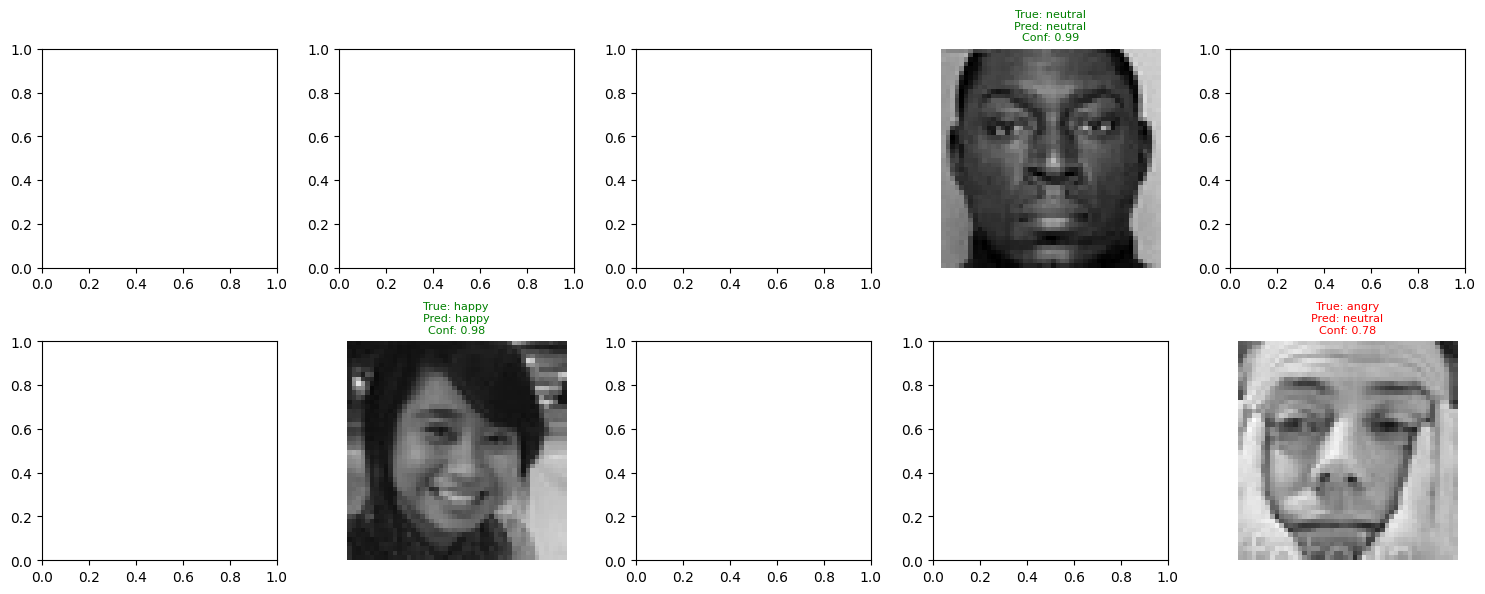


Batch Test Results:
Correct predictions: 2/3
Accuracy: 0.667


In [6]:
# Batch testing on multiple images
def batch_test_model(num_samples=10):
    """Test model on multiple random samples from test dataset"""
    import os
    import random
    
    print(f"Testing model on {num_samples} random samples...")
    
    correct_predictions = 0
    total_predictions = 0
    
    # Create figure for displaying results
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(num_samples):
        # Get random test image
        test_dir = 'data/test'
        emotion_folders = os.listdir(test_dir)
        random_emotion = random.choice(emotion_folders)
        
        if random_emotion in classes:
            emotion_path = os.path.join(test_dir, random_emotion)
            image_files = [f for f in os.listdir(emotion_path) if f.endswith('.jpg')]
            random_image = random.choice(image_files)
            image_path = os.path.join(emotion_path, random_image)
            
            # Load image
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Preprocess and predict
            processed_image = preprocess_image(image)
            predicted_emotion, confidence, _ = predict_emotion(processed_image)
            
            # Check if prediction is correct
            is_correct = predicted_emotion == random_emotion
            if is_correct:
                correct_predictions += 1
            total_predictions += 1
            
            # Display image
            axes[i].imshow(image_rgb)
            color = 'green' if is_correct else 'red'
            axes[i].set_title(f'True: {random_emotion}\nPred: {predicted_emotion}\nConf: {confidence:.2f}', 
                            color=color, fontsize=8)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\nBatch Test Results:")
    print(f"Correct predictions: {correct_predictions}/{total_predictions}")
    print(f"Accuracy: {accuracy:.3f}")
    
    return accuracy

# Run batch test
print("Running batch test on 10 random samples...")
batch_accuracy = batch_test_model(10)


In [ ]:
# Alternative demo without webcam - Interactive image selection
def interactive_image_demo():
    """Interactive demo where you can select images to test"""
    import os
    import random
    
    print("Interactive Image Demo - Model1_best")
    print("=" * 50)
    
    # Get all available test images
    test_dir = 'data/test'
    all_images = []
    
    for emotion in classes:
        emotion_path = os.path.join(test_dir, emotion)
        if os.path.exists(emotion_path):
            image_files = [f for f in os.listdir(emotion_path) if f.endswith('.jpg')]
            for img_file in image_files:
                all_images.append((emotion, os.path.join(emotion_path, img_file)))
    
    print(f"Found {len(all_images)} test images")
    
    # Test on random samples
    num_tests = 5
    print(f"\nTesting on {num_tests} random images...")
    
    correct = 0
    total = 0
    
    for i in range(num_tests):
        # Select random image
        true_emotion, image_path = random.choice(all_images)
        
        # Load and process image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed_image = preprocess_image(image)
        
        # Predict emotion
        predicted_emotion, confidence, all_predictions = predict_emotion(processed_image)
        
        # Check if correct
        is_correct = predicted_emotion == true_emotion
        if is_correct:
            correct += 1
        total += 1
        
        # Display results
        plt.figure(figsize=(15, 4))
        
        # Original image
        plt.subplot(1, 4, 1)
        plt.imshow(image_rgb)
        plt.title(f'Test {i+1}\nTrue: {true_emotion}', fontsize=12)
        plt.axis('off')
        
        # Processed image
        plt.subplot(1, 4, 2)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plt.imshow(gray_image, cmap='gray')
        plt.title('Processed (48x48)', fontsize=12)
        plt.axis('off')
        
        # Prediction bar chart
        plt.subplot(1, 4, 3)
        emotions = classes
        confidences = all_predictions
        colors = ['green' if e == predicted_emotion else 'lightblue' for e in emotions]
        
        bars = plt.bar(emotions, confidences, color=colors)
        plt.title(f'Predictions\nPredicted: {predicted_emotion}\nConfidence: {confidence:.3f}', fontsize=12)
        plt.ylabel('Confidence')
        plt.xticks(rotation=45)
        
        # Add confidence values on bars
        for bar, conf in zip(bars, confidences):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{conf:.3f}', ha='center', va='bottom', fontsize=8)
        
        # Result summary
        plt.subplot(1, 4, 4)
        result_text = f"Result: {'✓ CORRECT' if is_correct else '✗ WRONG'}\n"
        result_text += f"True: {true_emotion}\n"
        result_text += f"Predicted: {predicted_emotion}\n"
        result_text += f"Confidence: {confidence:.3f}\n"
        result_text += f"Accuracy so far: {correct}/{total} ({correct/total:.1%})"
        
        plt.text(0.1, 0.5, result_text, transform=plt.gca().transAxes, 
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen" if is_correct else "lightcoral"))
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Test {i+1}: True={true_emotion}, Predicted={predicted_emotion}, Correct={is_correct}")
    
    print(f"\nFinal Results:")
    print(f"Correct: {correct}/{total}")
    print(f"Accuracy: {correct/total:.1%}")
    
    return correct/total

# Run the interactive demo
interactive_accuracy = interactive_image_demo()
